# Generative AI

**What is Generative AI ?**

Generative AI is a subset of artificial intelligence that focuses on creating data, such as text, images, audio, or video, that resembles human-generated content. It uses techniques like neural networks and deep learning to understand patterns in existing data and generate new content. Applications include text and image generation, music composition, and data augmentation. Challenges include training complexity, content quality, and ethical concerns. The field continues to evolve, with potential applications in healthcare and increased attention to ethical considerations and regulations.


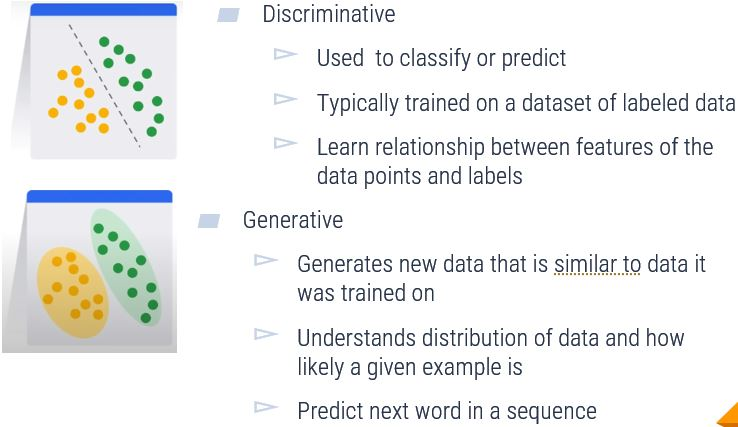

**What is Large Language Model Prompt?**

We can use instruction to train the pretrained model to help us to achieve our goal.

Example of the prompt instruction

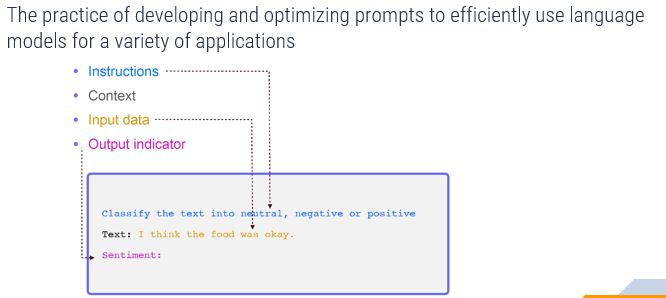



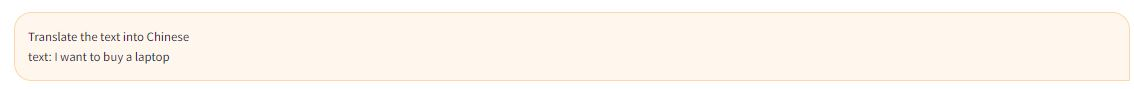


Result from the prompt

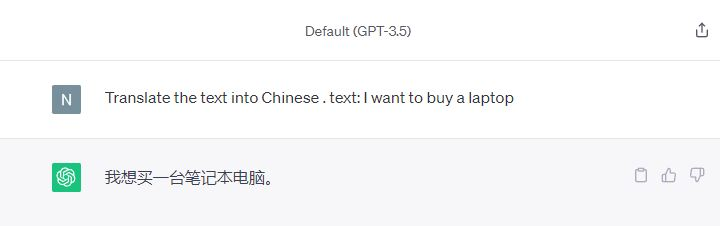


# Google Gemini Pro Usage via Gemini API and LangChain

It's exciting to see, **Gemini Pro** is available via API today.

Here are some key takeaways for developers:

- 32K context window for text, and a larger context window to come
- **free to use right now, within limits**
- features supported: `function calling`, `embeddings`, `semantic retrieval` and `custom knowledge grounding`, and `chat functionality`
- supports 38 languages across 180+ countries and territories worldwide
- Gemini Pro accepts text as input and generates text as output.
- A dedicated Gemini Pro Vision multimodal endpoint available today that accepts text and imagery as input, with text output.

## Get Your API Key

Visit [Google AI Studio](https://makersuite.google.com/) to create your *API Key*.

## Environment Preparation

Let's install the required Python packages. If you are not going to use LangChain, you can skip `langchain-google-genai`.

In [ ]:
! pip install -q --upgrade google-generativeai langchain-google-genai python-dotenv

In [ ]:
!pip install langchain

We could store the Google API Key created in the `.env` file and get it referenced by environmental variable.

```shell
GOOGLE_API_KEY=xxxxxxx
```

In [ ]:
from dotenv import load_dotenv
load_dotenv()

## Use Google Generative AI SDK to Access Gemini API

Let's define a helper function `to_markdown` to diplay the model output in a nicer way.

In [ ]:
from IPython.display import display
from IPython.display import Markdown
import textwrap


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

You could refer to the official documentation of the [Generative AI Python SDK](https://ai.google.dev/tutorials/python_quickstart).

In [ ]:
import google.generativeai as genai

In [ ]:
import os
genai.configure(api_key=os.environ.get("GOOGLE_API_KEY"))

### Text Generation

In [ ]:
model = genai.GenerativeModel(model_name = "gemini-pro")

In [ ]:
prompt_parts = [
    "Write a Python function and explain it to me",
]

response = model.generate_content(prompt_parts)

In [ ]:
print(response.text)

### Image Recognition

In this section, we will use the image from [Melody Zimmerman](https://unsplash.com/@roseonajourney) - [https://unsplash.com/photos/a-cup-of-coffee-next-to-a-plate-of-food-baNjp1eJAyo](https://unsplash.com/photos/a-cup-of-coffee-next-to-a-plate-of-food-baNjp1eJAyo)

In [ ]:
! pip install pillow

In [ ]:
import PIL.Image

img = PIL.Image.open('coffee-roll.jpg')
img

In [ ]:
model = genai.GenerativeModel('gemini-pro-vision')
response = model.generate_content(img)

to_markdown(response.text)

In [ ]:
response = model.generate_content(
    [
        "Write a short, engaging blog post based on this picture. It should include a description of the objects in the photo and talk about my journey in Tokyo.",
        img
    ],
    stream=False
)
response.resolve()
# to_markdown(response.text)

In [ ]:
to_markdown(response.text)

# What is LangChian?

* LangChain is a comprehensive framework designed specifically for creating applications utilizing language models.
* Its primary objective is to facilitate developers in constructing LLM-powered applications effortlessly. While LangChain is compatible with various LLMs, it particularly integrates seamlessly with OpenAI ChatGPT, benefiting from its advanced features.
* Prompt engineering plays a crucial role in shaping the behavior and responses of LLMs, and LangChain provides a flexible and efficient way to utilize them.


* The chains within LangChain serve the purpose of establishing a comprehensive pipeline for utilizing language models. They integrate the model, prompt, memory, parsing output, and debugging capabilities to offer a user-friendly interface

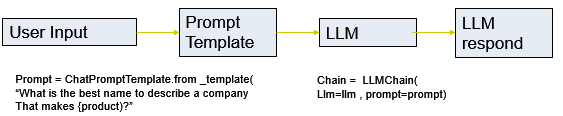


## Use LangChain to Access Gemini API

LangChain framework provides a wrapper class **ChatGoogleGenerativeAI** to invoke Gemini API.

By default, it looks for Google API Key in environmental variable `GOOGLE_API_KEY`.

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0.3)
result = llm.invoke("Give the sentiment value of this sentence : i don' like weather today")
to_markdown(result.content)

**With Prompt Template**

please note that the Gemini doesn’t support SystemMessage at the moment, but it can be added to the first human message in the row.

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.prompts import ChatPromptTemplate
from langchain.prompts import HumanMessagePromptTemplate

chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "return the sentiment for the given text in json fromat the sentiment value can be 'nagative','positive'"
            )
        ),
        HumanMessagePromptTemplate.from_template("{text}"),
    ]
)

chat_message =  chat_template.format_messages(text="i don' like weather today.")

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-pro",
                             temperature=0.3, convert_system_message_to_human=True) # set the convert_system_message_to_human to true

In [ ]:
llm.invoke(chat_message)

**Use the Output parser to get formatted output**

As observed, the desired output from the model is in JSON format. While the model provides us with the JSON, it is in string format. To rectify this, we can employ a Langchain output parser to convert the output into the correct JSON format.

In [ ]:
# import the json oupput parser from the langchain core
from langchain_core.output_parsers import JsonOutputParser

# define the parser object
parser = JsonOutputParser()

# create a chain
chain =  llm | parser

sentiment = chain.invoke(chat_message)

print(sentiment)

**Tagging Chain with Gemini Pro**

We can leverage the Pydantic parser or establish a tagging chain to present the information in a more informative manner.

In [ ]:
from typing import List

from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field, validator

define the tag pedantic object


In [ ]:
class Tags(BaseModel):
    sentiment: str = Field(..., enum=["happy", "neutral", "sad"])
    aggressiveness: int = Field(
        ...,
        description="describes how aggressive the statement is, the higher the number the more aggressive",
        enum=[1, 2, 3, 4, 5],
    )
    language: str = Field(
        ..., enum=["spanish", "english", "french", "german", "italian"]
    )

once defined create a chain

In [ ]:
# Set up a parser + inject instructions into the prompt template.
parser = PydanticOutputParser(pydantic_object=Tags)

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)


chain = prompt | llm | parser

chain.invoke({"query": "i don' like weather today."})

## Advanced Use Cases

In this section, we are going to cover some interesting use cases of Gemini Pro:

1. Chat conversation
2. Safety settings

#### Chat Conversation

Gemini managed conversations between the user and the model across multiple turns.

In [ ]:
model = genai.GenerativeModel('gemini-pro')
chat = model.start_chat(history=[])
chat

In [ ]:
response = chat.send_message("What is mixture of expert model?")
response

In [ ]:
to_markdown(response.text)

In [ ]:
response = chat.send_message("What was my first question?")
to_markdown(response.text)

#### Safety Settings

Gemini API enables developers to adjust safety settings on the following 4 dimensions to quickly assess if the application requires more or less restrictive configuration:

- Harassment
- Hate speech
- Sexually explicit
- Dangerous

By default, safety settings block content with medium and/or high probability of being unsafe content across all 4 dimensions, which is designed to work for most use cases. Develpers could also adjust its safety settings as needed.

The probability is rated in general as below:

- Negligible
- Low
- Medium
- High

To understand how it's exactly defined in API, please refer to the following documentation:

- [Harm Category](https://ai.google.dev/api/rest/v1beta/HarmCategory)
- [Harm Probability](https://ai.google.dev/api/rest/v1beta/SafetyRating#HarmProbability)



In [ ]:
response = model.generate_content('I am very anger')
response.candidates

Use `prompt_feedback` attribute of a response to see if it's blocked.

In [ ]:
response.prompt_feedback

User safety settings in a `generate_content` function call to customize. For example, if you're building a video game dialogue, you may deem it acceptable to allow more content that's rated as dangerous due to the nature of the game.

In [ ]:
safety_settings=[
    {
        "category": "HARM_CATEGORY_HARASSMENT",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_HATE_SPEECH",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
        "threshold": "BLOCK_NONE",
    }
]

response = model.generate_content(
    'I going to set fire to burn you down',
    safety_settings=safety_settings
)
response.candidates

In [ ]:
response.prompt_feedback

####Creating a Conversational bot with Gemini Pro and Langchain

We employ the ConversationChain from LCEL to craft a straightforward bot capable of answering questions based on the previous context. This innovative approach enables our bot to maintain context throughout the conversation, enhancing its ability to provide relevant and context-aware responses.

In [ ]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

conversation = ConversationChain(
    llm=llm,
    verbose=True,
    memory=ConversationBufferMemory()
)

In [ ]:
conversation.predict(input="Hi there!")

In [ ]:
conversation.predict(input="I'm doing well! Just having a conversation with an AI.")

Adding a custom prompt to the conversation chain

In [ ]:
PROMPT_TEMPLATE = """The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
{history}
Human: {input}
AI Assistant:
"""

PROMPT = PromptTemplate(
    input_variables=["history", "input"], template=PROMPT_TEMPLATE
)

In [ ]:
conversation = ConversationChain(
    llm=llm,
    verbose=True,
    prompt=PROMPT,
    memory=ConversationBufferMemory(ai_prefix="AI Assistant")
)

In [ ]:
conversation.predict(input="who is Gojo?")

In [ ]:
conversation.predict(input="What is his power?")